In [7]:
import act
from tempfile import TemporaryDirectory
import glob
import numpy as np
import pandas as pd
import datetime as dt
import altair as alt
pd.set_option('display.max_columns', 100)

import sys
sys.path.append("/home/elilouis/sublimationofsnow")

import sosutils
import seaborn as sns

# Inputs

In [8]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
# start_date = "2022-01-01"
# end_date = "2022-12-31"
start_date = "2022-12-01"
end_date = "2023-04-10"

DL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DL_DATA_STREAM_FILEEXT = '.nc'
DL_OUTPUT_DIR = os.path.join("/data2/elilouis/sublimationofsnow/", DL_DATA_STREAM)

SONDE_DATA_STREAM = 'gucsondewnpnM1.b1'
SONDE_DATA_STREAM_FILEEXT = '.cdf'
SONDE_OUTPUT_DIR = os.path.join("/data2/elilouis/sublimationofsnow/", SONDE_DATA_STREAM)

# Download DL data

In [ ]:
act.discovery.download_data(username, token, DL_DATA_STREAM, start_date, end_date, output=DL_OUTPUT_DIR)

# Download Sonde data

In [9]:
act.discovery.download_data(
            username, token, SONDE_DATA_STREAM, start_date, end_date, output = SONDE_OUTPUT_DIR)

[DOWNLOADING] gucsondewnpnM1.b1.20221201.232600.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221202.113600.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221203.232900.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221204.112700.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221202.235900.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221203.113200.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20230212.113000.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20230211.232900.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221205.113000.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221213.113100.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221212.232900.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221205.232500.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221206.233000.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221206.113400.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221207.113300.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221207.233000.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221208.112900.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221204.232500.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20221208.232700.cdf
[DOWNLOADING

['/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221201.232600.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221202.113600.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221203.232900.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221204.112700.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221202.235900.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221203.113200.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20230212.113000.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20230211.232900.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221205.113000.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20221213.113100.cdf',
 '/data2/elilouis/sublimationofsnow/gucsondewnpnM1.b1/gucson

# Open DL data

In [ ]:
dl_prof_files = glob.glob(os.path.join(DL_OUTPUT_DIR,'*'+DL_DATA_STREAM_FILEEXT))
print(len(dl_prof_files))
dl_prof = act.io.armfiles.read_netcdf(dl_prof_files)

In [ ]:
src_prof = dl_prof.to_dataframe().query('bound==0')

# Open Sonde data

In [10]:
sonde_files = glob.glob(os.path.join(SONDE_OUTPUT_DIR,'*'+SONDE_DATA_STREAM_FILEEXT))
print(len(sonde_files))
sonde = act.io.armfiles.read_netcdf(sonde_files)

928


In [11]:
src_sonde = sonde.to_dataframe()

# Check we have all the data we want

In [12]:
src_prof.base_time.min(), src_sonde.base_time.min()

NameError: name 'src_prof' is not defined

In [ ]:
src_prof.base_time.max(), src_sonde.base_time.max()

# Separate above/below ridgeline wind directions from Doppler LiDAR and average across heights

In [ ]:
below_ridge_winds = src_prof[src_prof.index.get_level_values(1) < 420]
above_ridge_winds = src_prof[src_prof.index.get_level_values(1) > 980]

In [ ]:
below_ridge_winds = below_ridge_winds['wind_direction'].groupby("time").apply(np.nanmedian)
above_ridge_winds = above_ridge_winds['wind_direction'].groupby("time").apply(np.nanmedian)

# Select range of pressures for Radiosonde winds and average across heights/pressures

In [13]:
synoptic_winds = src_sonde[np.abs(src_sonde['pres'] - 500) < 25]

In [14]:
synoptic_winds = synoptic_winds[['deg', 'wspd']].groupby("time").median()

In [15]:
synoptic_winds_local = sosutils.modify_df_timezone(synoptic_winds.reset_index(), 'UTC', 'US/Mountain')

In [16]:
src_sonde.columns

Index(['base_time', 'time_offset', 'pres', 'qc_pres', 'tdry', 'qc_tdry', 'dp',
       'qc_dp', 'wspd', 'qc_wspd', 'deg', 'qc_deg', 'rh', 'qc_rh', 'u_wind',
       'qc_u_wind', 'v_wind', 'qc_v_wind', 'wstat', 'asc', 'qc_asc', 'lat',
       'lon', 'alt'],
      dtype='object')

In [17]:
(
    alt.Chart(
        synoptic_winds_local.set_index('time').loc['2023-02-19':'2023-02-25'].reset_index()
    ).mark_bar().encode(
        alt.X('time:T', axis=alt.Axis(format = "%b %d"), title=""),
        alt.Y('wspd:Q', title='Speed (m/s)')
    ).properties(height = 100, width=100, title = "Synoptic Winds (500hPa, m/s)") | alt.Chart(
        synoptic_winds_local.set_index('time').loc['2023-03-16':'2023-03-20'].reset_index()
    ).mark_bar().encode(
        alt.X('time:T', axis=alt.Axis(format = "%b %d"), title=""),
        alt.Y('wspd:Q', title='Speed (m/s)')
    ).properties(height = 100, width=100, title = "Synoptic Winds (500hPa, m/s)") | alt.Chart(
        synoptic_winds_local.set_index('time').loc['2023-01-31':'2023-02-05'].reset_index()
    ).mark_bar().encode(
        alt.X('time:T', axis=alt.Axis(format = "%b %d"), title=""),
        alt.Y('wspd:Q', title='Speed (m/s)')
    ).properties(height = 100, width=100, title = "Synoptic Winds (500hPa, m/s)")
).resolve_scale(y="shared")

alt.HConcatChart(...)

In [ ]:
import pandas as pd
import altair as alt
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [ ]:
tidy_df = pd.read_csv('tidy_df_30Min_20230101_20230110_planar_fit.csv')

In [ ]:
def calculate_gradient_for_measurement(df, measurement='u'):
    # Group the DataFrame by "time" and "height"
    groups = df.query(f"measurement == '{measurement}'").groupby(["time", "tower"])

    # Define a function to fit a 2nd order polynomial to each group
    def fit_polynomial(group):
        x = [0] + list(group["height"].sort_values())
        y = [0] + list(group["value"].sort_values())
        coeffs = np.polyfit(x, y, 3)
        return pd.Series(coeffs, index=["a", "b", "c", "d"])
    def fit_polynomial_safely(group):
        try:
            return fit_polynomial(group)
        except SystemError:
            return pd.Series([np.nan, np.nan, np.nan(), np.nan], index=["a", "b", "c", "d"])

    # Apply the function to each group and store the results in a new DataFrame
    poly_coeffs_df = groups.apply(fit_polynomial_safely)
    return poly_coeffs_df

In [ ]:
def calculate gradient

In [ ]:
src_u = tidy_df.query("time == '2023-01-10 16:00:00'").query("tower == 'c'").query("measurement == 'wind speed'").sort_values("height")
src_v = tidy_df.query("time == '2023-01-10 16:00:00'").query("tower == 'c'").query("measurement == 'v'").sort_values("height")

In [ ]:
def log_linear_fn(z, a, b):
        z0 = 0.05 #(Sun et al., 2011)
        return a*np.log(z/z0) + b * (z/z0)
(a_u,b_u), _ = scipy.optimize.curve_fit(
    log_linear_fn,
    list(src_u.height),
    list(src_u.value),
)
(a_v,b_v), _ = scipy.optimize.curve_fit(
    log_linear_fn,
    list(src_v.height),
    list(src_v.value),
)

In [ ]:
poly_coeffs_df = calculate_gradient_for_measurement(tidy_df)


In [ ]:
estimates = [log_linear_fn(h, a, b) for h in ([0] + list(src.height))]

/tmp/ipykernel_203596/1939456553.py:3: RuntimeWarning: divide by zero encountered in log
  return a*np.log(z/z0) + b * (z/z0)


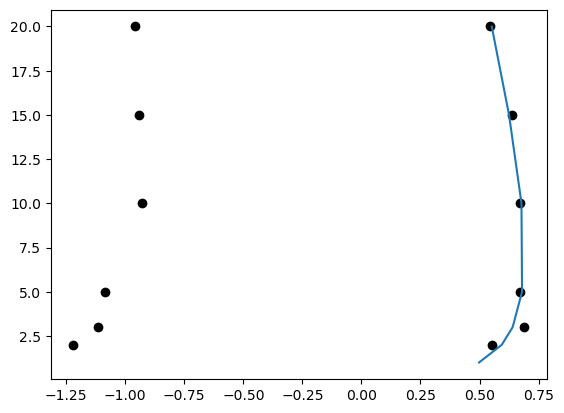

In [ ]:
h_values = [1,2,3,5,10,15,20]

u_estimates = [log_linear_fn(h, a_u, b_u) for h in h_values]
v_estimates = [log_linear_fn(h, a_v, b_v) for h in h_values]
plt.scatter(src_u.value, src_u.height, color='k')
plt.plot(u_estimates, h_values)
plt.scatter(src_v.value, src_v.height, color='k')
# plt.plot(v_estimates, h_values)

In [ ]:
def get_estimates(row, height_values):
    a,b,c,d = (row['a'], row['b'], row['c'], row['d'])
    estimates = [
        a + b*h + c*h**2 + d*h**3 for h in height_values
    ]
    return estimates



example_set = poly_coeffs_df.query("time == '2023-01-10 16:00:00'").query("tower == 'c'")
estimates = get_estimates(example_set.iloc[0], [0,1,2,3,5,10,15,20])
estimates

plt.scatter(src.value, src.height)
plt.scatter(estimates, [0,1,2,3,5,10,15,20])
plt.xlim(0, 1)

In [ ]:
poly_coeffs_df.loc[poly_coeffs_df.index[0]]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot()

In [ ]:
x, y

In [ ]:
poly_coeffs_df

In [ ]:
# create an empty list to hold the gradient values
gradient_values = []

groups = tidy_df.query("measurement == 'u'").groupby(["time", "tower"])


# loop through each group
for name, group in groups:
    # extract the values from the "height" and "value" columns
    x = group["height"].values
    y = group["value"].values

    # fit a second-order polynomial to the data
    coeffs = np.polyfit(y, x, 2)
    
#     deriv = np.polyder(coeffs)
#     # calculate the gradient of the fitted polynomial
#     gradient = 2 * coeffs[0] * x + coeffs[1]
    
#     # add the gradient values to the list
#     gradient_values.append(gradient)
    
# # convert the list of gradient values to a pandas DataFrame
# gradient_df = pd.DataFrame(gradient_values)

# # add columns for the "time" and "tower" values
# gradient_df["time"] = groups.apply(lambda x: x["time"].iloc[0]).values
# gradient_df["tower"] = groups.apply(lambda x: x["tower"].iloc[0]).values

# # rename the columns to something more descriptive
# gradient_df.columns = ["gradient", "time", "tower"]


In [ ]:
gradient_df

In [ ]:
# groupby: tower, height: time 

# Plot profiles of u, temperature, and humidity

# Fit 3 functions to 3 profiles

# Calculate shear at each height, interpolating with your fit
    # How to calculate shear?
    # 1. Differentiate the fitted function get value
    # 2. use the two sensors on either side?

# Assign calculated shear values to tidy_df

# calculate R^2 of fit

tidy_df

In [ ]:
g = tidy_df.groupby(['tower', 'height', 'time'])

In [ ]:
df = g.get_group(list(g.groups)[500])


In [ ]:
tidy_df.tower.unique()

In [ ]:
tidy_df.query("measurement == 'u'")

# Resample Doppler LiDAR and Sonde Wind Directions

In [ ]:
synoptic_winds = synoptic_winds.resample("720Min").median() # 12 hours
below_ridge_winds = below_ridge_winds.resample("720Min").median()
above_ridge_winds = above_ridge_winds.resample("720Min").median()

# Combine data and categorize "day vs night" and "synoptically weak vs strong"


In [ ]:
wind_comparison_df = pd.DataFrame({
    '500hpa wind dir': synoptic_winds['deg'],
    '500hpa wind speed': synoptic_winds['wspd'],
    'below ridgeline wind dir': below_ridge_winds,
    'above ridgeline wind dir': above_ridge_winds,
}).reset_index()

In [ ]:
sns.distplot(wind_comparison_df['500hpa wind speed'], bins=100, kde=False, norm_hist=True)

In [ ]:
wind_comparison_df = sosutils.modify_df_timezone(wind_comparison_df, 'UTC', "US/Mountain")
wind_comparison_df['time of day'] = wind_comparison_df['time'].apply(lambda t: 'night' if t.hour == 5 else 'day')
wind_comparison_df['synoptic strength'] = wind_comparison_df['500hpa wind speed'].apply(lambda spd: "weak" if spd < 12 else "strong")
wind_comparison_df['season'] = wind_comparison_df['time'].apply(lambda dt: 'winter' if dt.month in [11,12,1,2,3,4,5] else 'summer')

In [ ]:
axis = alt.Axis(values=[0,90,180,270, 360])
scale = alt.Scale(domain=[0,360], nice=False)

c1 = alt.Chart(wind_comparison_df).mark_circle(size=10).encode(
    alt.X("500hpa wind dir:Q", axis=axis, scale=scale),
    alt.Y("above ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

c2 = alt.Chart(wind_comparison_df).mark_circle(size=10).encode(
    alt.X("500hpa wind dir:Q", axis=axis, scale=scale),
    alt.Y("below ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

c3 = alt.Chart(wind_comparison_df).mark_circle(size=10).encode(
    alt.X("above ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Y("below ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

(c1.properties(title='A') | c2.properties(title='B') | c3.properties(title='C'))

In [ ]:
axis = alt.Axis(values=[0,90,180,270, 360])
scale = alt.Scale(domain=[0,360], nice=False)

c1 = alt.Chart(wind_comparison_df).mark_rect().encode(
    alt.X('500hpa wind dir:Q', bin=alt.Bin(maxbins=50), axis=axis, scale=scale),
    alt.Y('above ridgeline wind dir:Q', bin=alt.Bin(maxbins=50), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

c2 = alt.Chart(wind_comparison_df).mark_rect().encode(
    alt.X('500hpa wind dir:Q', bin=alt.Bin(maxbins=50), axis=axis, scale=scale),
    alt.Y('below ridgeline wind dir:Q', bin=alt.Bin(maxbins=50), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

c3 = alt.Chart(wind_comparison_df).mark_rect().encode(
    alt.X('above ridgeline wind dir:Q', bin=alt.Bin(maxbins=50), axis=axis, scale=scale),
    alt.Y('below ridgeline wind dir:Q', bin=alt.Bin(maxbins=50), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

(c1.properties(title='A') | c2.properties(title='B') | c3.properties(title='C'))

In [ ]:
src = wind_comparison_df.query("season == 'winter'")

c1 = alt.Chart(src).mark_circle(size=10).encode(
    alt.X("500hpa wind dir:Q", axis=axis, scale=scale),
    alt.Y("above ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

c2 = alt.Chart(src).mark_circle(size=10).encode(
    alt.X("500hpa wind dir:Q", axis=axis, scale=scale),
    alt.Y("below ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

c3 = alt.Chart(src).mark_circle(size=10).encode(
    alt.X("above ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Y("below ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

snow_on_plots = (c1.properties(title='Snow On') | c2.properties(title='Snow On') | c3.properties(title='Snow On'))

In [ ]:
axis = alt.Axis(values=[0,90,180,270, 360])
scale = alt.Scale(domain=[0,360], nice=False)

src = wind_comparison_df.query("season == 'summer'")

c1 = alt.Chart(src).mark_circle(size=10).encode(
    alt.X("500hpa wind dir:Q", axis=axis, scale=scale),
    alt.Y("above ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

c2 = alt.Chart(src).mark_circle(size=10).encode(
    alt.X("500hpa wind dir:Q", axis=axis, scale=scale),
    alt.Y("below ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

c3 = alt.Chart(src).mark_circle(size=10).encode(
    alt.X("above ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Y("below ridgeline wind dir:Q", axis=axis, scale=scale),
    alt.Color("synoptic strength:N"),
    # alt.Facet("time of day:N")
).properties(width=150, height = 150)

snow_off_plots = (c1.properties(title='Snow Off') | c2.properties(title='Snow Off') | c3.properties(title='Snow Off'))

In [ ]:
snow_on_plots & snow_off_plots

In [ ]:
src = wind_comparison_df.query("season == 'winter'")

c1 = alt.Chart(src).mark_rect().encode(
    alt.X('500hpa wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Y('above ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

c2 = alt.Chart(src).mark_rect().encode(
    alt.X('500hpa wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Y('below ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

c3 = alt.Chart(src).mark_rect().encode(
    alt.X('above ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Y('below ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

snow_on_plots = (c1.properties(title='Snow On') | c2.properties(title='Snow On') | c3.properties(title='Snow On'))

In [ ]:
src = wind_comparison_df.query("season == 'summer'")

c1 = alt.Chart(src).mark_rect().encode(
    alt.X('500hpa wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Y('above ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

c2 = alt.Chart(src).mark_rect().encode(
    alt.X('500hpa wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Y('below ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

c3 = alt.Chart(src).mark_rect().encode(
    alt.X('above ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Y('below ridgeline wind dir:Q', bin=alt.Bin(maxbins=25), axis=axis, scale=scale),
    alt.Color('count():Q', scale=alt.Scale(scheme='greenblue'))
).properties(width=150, height = 150)

snow_off_plots = (c1.properties(title='Snow Off') | c2.properties(title='Snow Off') | c3.properties(title='Snow Off'))

In [ ]:
(snow_on_plots & snow_off_plots).resolve_scale(color='independent')

**Conclusions drawn**

Panel A:
* Upper level flow is nearly always between 180 and 360˚, so mostly westerly with lots of deviations to SSW and NNW.
* Above ridgeline winds measured by the Doppler Lidar and 500hPa winds measured by the Sonde are mostly in agreement. They are nearly always in agreement when synoptic winds are strong. There are a good number of cases where they do not agree, but in nearly all of those instances, synoptic winds were weak.

Panel B:
* There are two main regimes of below ridgeline wind direction, which approximately align with up and downvalley direction: 135-180˚ and around 315˚. The downvalley (315˚) valley-scale wind regime exists fairly equally at all 500hPa wind directions. The upvalley (135-180˚) valley-scale wind regime favors 500hPa windsdirections between South-Southwest and West.
* These relationships seem to hold for both strong and weak synoptics.

Panel C:
* Same conclusions as Panel B. i.e....
* Comparing the above/below ridgeline winds (measured by the DL) reveals the same relationship as comparing DL below ridgeline winds with the Sonde measured synoptic scale winds due to the agreement between above-ridgeline DL measurements and 500hPa sonde measuremenrs (see Panel A)